In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna
import pickle
import plotly.express as px

from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance

import sys
import os
from tqdm import tqdm

RAND = 10
N_FOLDS = 3
TIMEOUT = 90000
N_TRIALS = 100

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
model_path = os.path.abspath('../models')
sys.path.append(model_path)
from get_metrics import get_metrics_regression
from check_overfitting import check_overfitting

# Import data

In [19]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

In [20]:
df[:3]

,milliseconds,place,status,tsunami,significance,data_type,magnitude,country,longitude,latitude,depth,datetime,timezone,magnitude_bins,year,month,day,hour,minute,second
0,1668773163070,"14 km SSE of Eden Roc, Hawaii",automatic,0,58,earthquake,1.94,USA,-155.030334,19.374001,7.10,2022-11-18 12:06:03,+00:00,green,2022,11,18,12,6,3
1,1668773284487,"40 km ESE of Nikolski, Alaska",reviewed,0,62,earthquake,2.00,USA,-168.310800,52.786100,64.90,2022-11-18 12:08:04,+00:00,green,2022,11,18,12,8,4
2,1668773482790,"45 km SW of Howell, Utah",reviewed,0,21,earthquake,1.16,USA,-112.845833,41.512167,5.73,2022-11-18 12:11:22,+00:00,green,2022,11,18,12,11,22


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94354 entries, 0 to 94353
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   milliseconds    94354 non-null  int64  
 1   place           94354 non-null  object 
 2   status          94354 non-null  object 
 3   tsunami         94354 non-null  int64  
 4   significance    94354 non-null  int64  
 5   data_type       94354 non-null  object 
 6   magnitude       94354 non-null  float64
 7   country         94354 non-null  object 
 8   longitude       94354 non-null  float64
 9   latitude        94354 non-null  float64
 10  depth           94354 non-null  float64
 11  datetime        94354 non-null  object 
 12  timezone        94354 non-null  object 
 13  magnitude_bins  94354 non-null  object 
 14  year            94354 non-null  int64  
 15  month           94354 non-null  int64  
 16  day             94354 non-null  int64  
 17  hour            94354 non-null 

In [22]:
# основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,tsunami,significance,magnitude,longitude,latitude,depth,year,month,day,hour,minute,second
count,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000,94354.000000
mean,0.000964,67.406363,1.720177,-116.542011,41.560005,26.813648,2022.824915,5.299479,15.482046,11.486010,29.419537,29.468290
std,0.031041,96.398645,1.178204,72.358151,20.357130,56.179701,0.380042,3.429028,8.635858,6.920763,17.357370,17.283395
min,0.000000,0.000000,0.000000,-179.998700,-65.425400,-3.740000,2022.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,14.000000,0.950000,-153.445775,34.018333,3.400000,2023.000000,3.000000,8.000000,6.000000,14.000000,15.000000
50%,0.000000,30.000000,1.400000,-122.852500,39.246300,9.200000,2023.000000,5.000000,16.000000,11.000000,29.000000,29.000000
75%,0.000000,68.000000,2.100000,-116.717375,58.264000,25.600000,2023.000000,7.000000,23.000000,17.000000,45.000000,44.000000
max,1.000000,2910.000000,7.800000,179.999400,86.593900,681.238000,2023.000000,12.000000,30.000000,23.000000,59.000000,59.000000


In [23]:
# основные описательные статистики для булевых и категориальных признаков
df.describe(include=["object", "bool"])

,place,status,data_type,country,datetime,timezone,magnitude_bins
count,94354,94354,94354,94354,94354,94354,94354
unique,34095,3,7,234,93284,1,3
top,"8km NW of The Geysers, CA",reviewed,earthquake,USA,2023-03-02 18:11:07,+00:00,green
freq,973,84325,92210,80057,2,94354,82184


# LabelEncoder

In [24]:
# создаем LabelEncoder для кодирования категориальных значений
le = LabelEncoder()

# список категориальных столбцов
categorical_cols = df.select_dtypes(include=[object]).columns

# кодируем каждый категориальный столбец
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

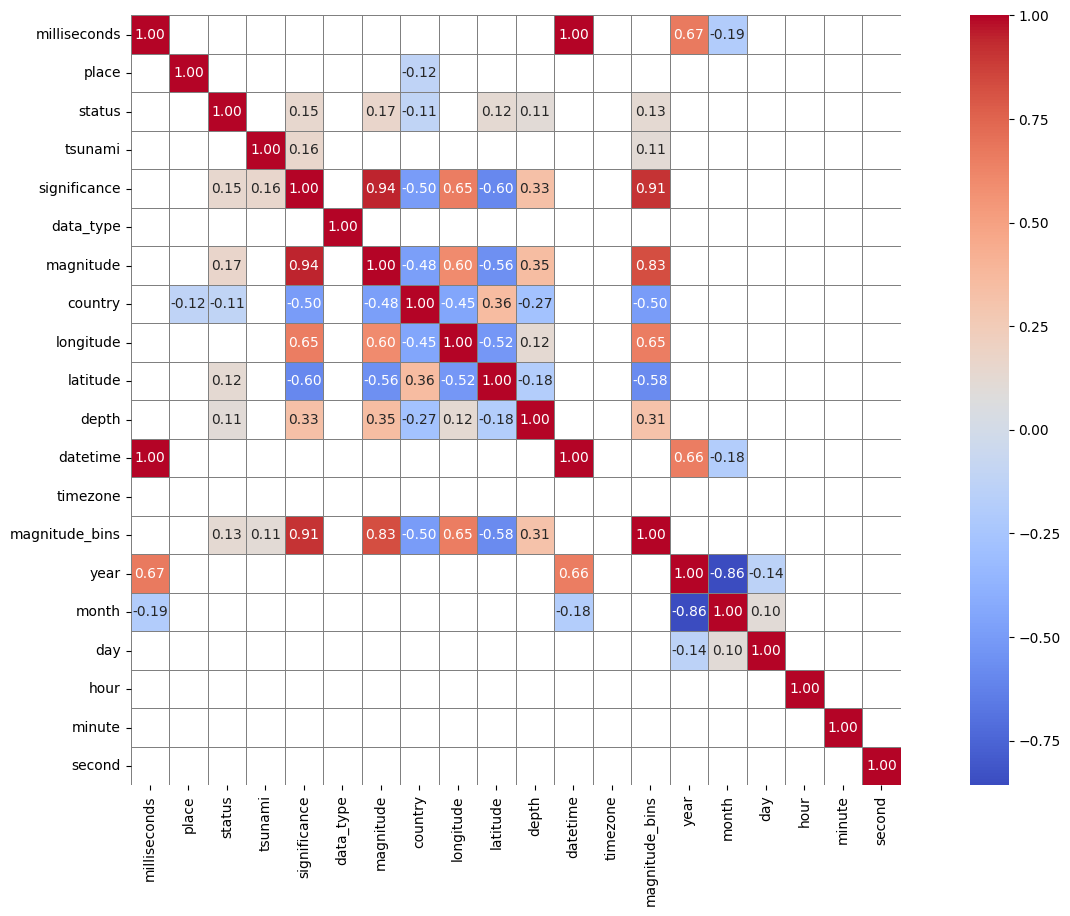

In [25]:
# рассчитываем матрицу корреляции
corr_matrix = df.corr()

# создаем маску
mask = np.abs(corr_matrix) < 0.1

# указывает размер графика
plt.figure(figsize=(18, 10))

# создаем тепловую карту матрицы корреляции
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f', mask=mask, linewidths=0.5, linecolor='grey')

# Показываем график
plt.show()

In [26]:
df.columns

Index(['milliseconds', 'place', 'status', 'tsunami', 'significance',
       'data_type', 'magnitude', 'country', 'longitude', 'latitude', 'depth',
       'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day',
       'hour', 'minute', 'second'],
      dtype='object')

# permutation_importance

In [27]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        # 'magnitude',
        # 'longitude',
        # 'latitude'
        ]]

# целевые переменные
y = df[[
    'magnitude',
    'longitude',
    'latitude'
    ]]

In [28]:
y[:5]

,magnitude,longitude,latitude
0,1.94,-155.030334,19.374001
1,2.00,-168.310800,52.786100
2,1.16,-112.845833,41.512167
3,0.90,-149.622800,61.883600
4,1.60,-152.553400,60.144300


In [29]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

Модель RandomForestRegressor(random_state=10):
['country', 'significance', 'place', 'depth', 'status']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['significance', 'country', 'place', 'depth', 'status', 'magnitude_bins']

Модель DecisionTreeRegressor(random_state=10):
['country', 'significance', 'place', 'depth', 'datetime', 'milliseconds', 'status', 'day', 'hour', 'minute', 'second', 'month']

Общие важные признаки для моделей:
['status', 'country', 'depth', 'place', 'significance']


In [30]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        # 'magnitude',
        'longitude',
        'latitude'
        ]]

# целевые переменные
y = df[[
    'magnitude',
    # 'longitude',
    # 'latitude'
    ]]

In [31]:
y[:5]

,magnitude
0,1.94
1,2.00
2,1.16
3,0.90
4,1.60


In [32]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Модель RandomForestRegressor(random_state=10):
['significance', 'magnitude_bins']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['significance', 'magnitude_bins']

Модель DecisionTreeRegressor(random_state=10):
['significance', 'magnitude_bins']

Общие важные признаки для моделей:
['magnitude_bins', 'significance']


In [33]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        'magnitude',
        # 'longitude',
        # 'latitude'
        ]]

# целевые переменные
y = df[[
    # 'magnitude',
    'longitude',
    'latitude'
    ]]

In [34]:
y[:5]

,longitude,latitude
0,-155.030334,19.374001
1,-168.310800,52.786100
2,-112.845833,41.512167
3,-149.622800,61.883600
4,-152.553400,60.144300


In [35]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

Модель RandomForestRegressor(random_state=10):
['country', 'magnitude', 'place', 'depth', 'status', 'significance', 'datetime', 'milliseconds']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['country', 'magnitude', 'place', 'depth', 'status', 'significance']

Модель DecisionTreeRegressor(random_state=10):
['country', 'magnitude', 'place', 'depth', 'significance', 'milliseconds', 'datetime', 'status', 'day', 'hour', 'minute', 'second', 'month']

Общие важные признаки для моделей:
['status', 'country', 'depth', 'magnitude', 'place', 'significance']


In [36]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        'magnitude',
        'longitude',
        # 'latitude'
        ]]

# целевые переменные
y = df[[
    # 'magnitude',
#     'longitude',
    'latitude'
    ]]

In [37]:
y[:5]

,latitude
0,19.374001
1,52.786100
2,41.512167
3,61.883600
4,60.144300


In [38]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Модель RandomForestRegressor(random_state=10):
['longitude', 'country', 'magnitude', 'place', 'status', 'depth']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['longitude', 'magnitude', 'country', 'status', 'place']

Модель DecisionTreeRegressor(random_state=10):
['longitude', 'country', 'magnitude', 'place', 'status', 'depth', 'significance']

Общие важные признаки для моделей:
['status', 'country', 'magnitude', 'place', 'longitude']


In [39]:
# признаки
X = df[['milliseconds', 'place', 'status', 'tsunami', 'significance', 'data_type', 'country', 'depth',
        'datetime', 'timezone', 'magnitude_bins', 'year', 'month', 'day', 'hour', 'minute', 'second',
        'magnitude',
        # 'longitude',
        'latitude'
        ]]

# целевые переменные
y = df[[
    # 'magnitude',
    'longitude',
#     'latitude'
    ]]

In [40]:
y[:5]

,longitude
0,-155.030334
1,-168.310800
2,-112.845833
3,-149.622800
4,-152.553400


In [41]:
# создаем лист с моделям
models = [
    RandomForestRegressor(random_state=RAND),
    MultiOutputRegressor(GradientBoostingRegressor(random_state=RAND)),
    DecisionTreeRegressor(random_state=RAND),
]

# тренируем модели
for model in models:
    model.fit(X, y)

# оцениваем важность признаков для каждой модели
important_features_models = []
for model in models:
    importances_result = permutation_importance(model, X, y, n_repeats=3, random_state=RAND)
    importances = importances_result.importances_mean
    
    # Ссортируем признаки по важности
    sorted_importances = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
    
    # выводим важность признаков для каждой модели
    print(f"Модель {model}:")
    important_features_model = [feature for feature, importance in sorted_importances if importance >= 0.01]
    print(important_features_model)
    print()
    
    important_features_models.append(important_features_model)

# находим повторяющиеся значения в списках
common_features = set.intersection(*[set(features) for features in important_features_models])

print("Общие важные признаки для моделей:")
print(list(common_features))

c:\Users\myxa-\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Модель RandomForestRegressor(random_state=10):
['country', 'latitude', 'magnitude', 'place', 'depth']

Модель MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=10)):
['magnitude', 'country', 'latitude', 'place']

Модель DecisionTreeRegressor(random_state=10):
['country', 'latitude', 'magnitude', 'place', 'depth', 'datetime', 'significance']

Общие важные признаки для моделей:
['magnitude', 'country', 'place', 'latitude']
